## Packages

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [2]:
#gráfica ce flux vs EM y T
def plot_xrs_vs_te_simple(days, 
                         df_full_valid, 
                         df_flares_valid, 
                         time_column="PeakTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by=None,
                         palette="viridis",  
                         class_to_color=None):
    """
    Versión simplificada que asume que podemos hacer merge por tiempo
    """
    
    # Convertir a datetime
    df_full_valid['date'] = pd.to_datetime(df_full_valid['date'])
    df_flares_valid[time_column] = pd.to_datetime(df_flares_valid[time_column])
    
    # Hacer merge de los dataframes
    df_merged = pd.merge(df_flares_valid, df_full_valid, 
                        left_on=time_column, 
                        right_on='date', 
                        how='inner')
    
    if len(df_merged) == 0:
        print("No hay coincidencias entre los dataframes.")
        return
    
    # Filtrar datos válidos
    valid_data = df_merged.dropna(subset=[XRS, T, EM])
    
    if len(valid_data) == 0:
        print("No hay datos válidos después de filtrar NaNs.")
        return
    
    print(f"Datos válidos para graficar: {len(valid_data)}")
    
    # Preparar datos
    xrs_vals = valid_data[XRS].values
    em_vals = valid_data[EM].values
    t_vals = valid_data[T].values
    
    # Preparar labels para colores
    if color_by == "Class":
        flare_labels = valid_data["Class"].astype(str).str[0].tolist()  # solo letra B,C,M,X
    elif color_by == "Date":
        flare_labels = valid_data[time_column].dt.date.astype(str).tolist()
    elif color_by == "observatory":
        flare_labels = valid_data["observatory"].fillna("Unknown").tolist()
    else:
        flare_labels = [""] * len(valid_data)

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Configuración de plot
    plt.rcParams.update({
        "axes.titlesize": 17, "axes.labelsize": 15,
        "xtick.labelsize": 16, "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[0].set_xlabel(rf"EM$_{{49}}$ [cm$^{{-3}}$]")
    axes[0].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[0].set_title(f"X-ray flux vs Emission Measure\n{days} days ({time_column})", pad=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlim(0.001, None)
    
    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[1].set_xlabel(f"T [MK]")
    axes[1].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[1].set_title(f"X-ray flux vs Temperature\n{days} days ({time_column})", pad=20)
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, 30)

    # Leyenda
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                             label=str(lab), markersize=12) for lab in labels]
        
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left
        
        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        fig.legend(handles=handles, title=color_by,
                  loc="upper center", bbox_to_anchor=(0.5, -0.05),
                  ncol=min(4, len(labels)), frameon=False,
                  title_fontsize=17) #tamaño de título

    # Guardar
    output_name = f"{days}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

def plot_anticipation_vs_te_dataframes(days,
                                      max_gap_fai,
                                      df_full_valid,
                                      df_flares_valid,
                                      df_anticipation_time,
                                      time_column="PeakTime",
                                      T="T_cor", 
                                      EM="EM_cor_norm",
                                      color_by=None,        # "Class" o "Date" u "Observatory"
                                      palette="viridis",
                                      class_to_color=None  # dict de colores fijos
                                      ):
    """
    Grafica:
      - T vs tiempo de anticipación
      - EM vs tiempo de anticipación
    usando los dataframes directamente.

    Parameters:
    - days: número de días analizados
    - max_gap_fai: ventana máxima de tiempo para FAI
    - df_full_valid: DataFrame con datos GOES completos
    - df_flares_valid: DataFrame con datos de fulguraciones
    - df_anticipation_time: DataFrame con tiempos de anticipación
    - time_column: columna de tiempo a usar ('PeakTime', 'StartTime', etc.)
    - T: columna de temperatura a usar
    - EM: columna de medida de emisión a usar
    - color_by: "Class", "Date", "Observatory" o None
    - palette: paleta de colores
    - class_to_color: diccionario de colores fijos
    """

    # Crear copias para no modificar los originales
    df_full = df_full_valid.copy()
    df_flares = df_flares_valid.copy()
    df_anticipation = df_anticipation_time.copy()

    # Convertir columnas de fecha a datetime si no lo están
    df_full['date'] = pd.to_datetime(df_full['date'])
    df_flares[time_column] = pd.to_datetime(df_flares[time_column])
    df_anticipation[time_column] = pd.to_datetime(df_anticipation[time_column])

    # Identificar la columna de anticipación (puede tener diferentes nombres)
    anticipation_col = None
    for col in ['AnticipationStart', 'AnticipationPeak', 'Anticipation (min)']:
        if col in df_anticipation.columns:
            anticipation_col = col
            break
    
    if anticipation_col is None:
        # Buscar cualquier columna que contenga "Anticipation"
        anticipation_cols = [col for col in df_anticipation.columns if 'Anticipation' in col]
        if anticipation_cols:
            anticipation_col = anticipation_cols[0]
        else:
            raise ValueError("No se encontró columna de anticipación en df_anticipation_time")

    print(f"Usando columna de anticipación: {anticipation_col}")

    anticipation_vals, t_vals, em_vals, flare_labels = [], [], [], []

    # Recorremos cada flare
    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]

        # Buscar anticipación en el dataframe correspondiente
        mask = df_anticipation[time_column] == flare_time
        row_ant = df_anticipation[mask]
        
        if row_ant.empty:
            continue

        delta_minutes = row_ant[anticipation_col].values[0]

        # Buscar datos físicos en df_full_valid (búsqueda por tiempo más cercano)
        time_diff = np.abs(df_full['date'] - flare_time)
        if len(time_diff) > 0:
            closest_idx = time_diff.argmin()
            flare_row = df_full.iloc[closest_idx]
            
            # Verificar que tenemos los datos necesarios
            if (pd.notna(flare_row[T]) and pd.notna(flare_row[EM]) and 
                pd.notna(delta_minutes) and delta_minutes > 0):
                
                anticipation_vals.append(delta_minutes)
                t_vals.append(flare_row[T])
                em_vals.append(flare_row[EM])

                if color_by == "Class":
                    flare_labels.append(str(flare["Class"])[0])   # letra de clase
                elif color_by == "Date":
                    flare_labels.append(flare_time.date())
                elif color_by == "Observatory":
                    # Usar observatorio del flare o del dato GOES
                    obs = flare.get("Observatory", flare_row.get("observatory", "Unknown"))
                    flare_labels.append(obs)
                else:
                    flare_labels.append("")

    # Verificar que tenemos datos
    if len(anticipation_vals) == 0:
        print("No se encontraron datos válidos para graficar")
        return

    print(f"Datos procesados: {len(anticipation_vals)} flares con anticipación")

    # --- Colores ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # --- Subplots ---
    plt.rcParams.update({
        "axes.titlesize": 15,
        "axes.labelsize": 16,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "legend.fontsize": 10 
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # T vs Anticipación
    scatter1 = axes[0].scatter(t_vals, anticipation_vals, c=colors, alpha=0.7, s=50)
    axes[0].set_xlabel(f"{T} [MK]")
    axes[0].set_xlim(0, 30)   # T en el rango de 0 a 30 MK
    axes[0].set_ylabel("Anticipation Time [min]")
    axes[0].set_title(f"Temperature vs Anticipation\n({days} days, Window={max_gap_fai} min)")
    axes[0].set_yscale("log")   # Escala log en Y

    # EM vs Anticipación
    scatter2 = axes[1].scatter(em_vals, anticipation_vals, c=colors, alpha=0.7, s=50)
    axes[1].set_xlabel(rf"{EM} [cm$^{{-3}}$]")
    axes[1].set_ylabel("Anticipation Time [min]")
    axes[1].set_title(f"Emission Measure vs Anticipation\n({days} days, Window={max_gap_fai} min)")
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")   # Y en log

    # --- Formato personalizado para logs ---
    def log_format(x, pos):
        # Si es un entero, mostrarlo sin decimales
        if x >= 1:
            return f"{int(x)}"
        else:
            # Para los menores de 1, mostrar en notación decimal normal
            return f"{x:.3f}".rstrip("0").rstrip(".")

    formatter = FuncFormatter(log_format)

    for ax in axes:
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        
        # Añadir grid para mejor lectura
        ax.grid(True, alpha=0.3)

    # --- Leyenda ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab), markersize=8) for lab in labels]
        fig.legend(handles=handles, title=color_by,
                   loc="upper center",
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=min(len(labels), 8),
                   frameon=False,
                   fontsize=10)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Guardar
    output_name = f"{days}d_AnticipationTime_vs_T_EM_Window{max_gap_fai}min_Color{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas
    print(f"\n--- Estadísticas de Anticipación ---")
    print(f"Tiempo de anticipación promedio: {np.mean(anticipation_vals):.1f} min")
    print(f"Tiempo de anticipación mediano: {np.median(anticipation_vals):.1f} min")
    print(f"Tiempo de anticipación máximo: {np.max(anticipation_vals):.1f} min")
    print(f"Tiempo de anticipación mínimo: {np.min(anticipation_vals):.1f} min")
    print(f"Temperatura promedio: {np.mean(t_vals):.1f} MK")
    print(f"EM promedio: {np.mean(em_vals):.3f}")


##

## Parameters

In [3]:
n=185
# nuevo número de días
new_n = 148
fecha_actual = "2025-11-11"

window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
filter_flare_coincidence = True
method = "filtered" # "all", "true" o "filtered"

## Carpeta para gráficas

In [4]:
analysis_dir = os.path.join(f"Analysis_FAI")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_dir ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_dir }")
else:
    os.makedirs(analysis_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_dir}")

# Crear subcarpeta para guardar resultados de análisis
analysis_esp = os.path.join(analysis_dir, f"Analysis_FAI_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min")
# Crear carpeta de análisis (si no existe) y mostrar mensaje
if os.path.exists(analysis_esp ):
    print(f"⚠️ La carpeta de análisis ya existía: {analysis_esp }")
else:
    os.makedirs(analysis_esp , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {analysis_esp}")

folder = f"Graphics_{method}_W{window_minutes}min"

# Crear subcarpeta para guardar resultados de análisis
graphics_dir = os.path.join(analysis_esp, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {graphics_dir}")




⚠️ La carpeta de análisis ya existía: Analysis_FAI
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min
⚠️ La carpeta de análisis ya existía: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min


## Valid Data 

In [5]:
output_dir = f"Data_for_{n}_days"

# Path of cleaned data in csv
csv_path_full_valid = f"{output_dir}/df_full_{new_n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{output_dir}/df_flares_{new_n}_valid.csv"
# Path of df_full
csv_path_full = f"{output_dir}/all_df_full_{n}.csv"

# Verificar existencia de archivos y avisar
if not os.path.exists(csv_path_full_valid):
    print(f"⚠️ No se encontró el archivo GOES: {csv_path_full_valid}")
else:
    print(f"✅ Archivo GOES encontrado: {csv_path_full_valid}")

if not os.path.exists(csv_path_flares):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_flares}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_flares}")

if not os.path.exists(csv_path_full):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_full}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_full}")

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_full = pd.read_csv(csv_path_full)

✅ Archivo GOES encontrado: Data_for_185_days/df_full_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/df_flares_148_valid.csv
✅ Archivo de flares encontrado: Data_for_185_days/all_df_full_185.csv


## Data_method

In [6]:
# Path of anticipation_time
csv_path_anticipation_time = f"{analysis_esp}/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{analysis_esp}/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{analysis_esp}/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{analysis_esp}/df_fai_assoc2_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

if not os.path.exists(csv_path_anticipation_time):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_anticipation_time}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_anticipation_time}")
if not os.path.exists(csv_path_fai_all):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_all}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_all}")
if not os.path.exists(csv_path_fai_selected):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_selected}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_selected}")
if not os.path.exists(csv_path_fai_assoc):
    print(f"⚠️ No se encontró el archivo de flares: {csv_path_fai_assoc}")
else:
    print(f"✅ Archivo de flares encontrado: {csv_path_fai_assoc}")


df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)



✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_anticipation_time_filtered_(W_30)_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_all_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_filtered_T7-14_EM0.005_dur3min.csv
✅ Archivo de flares encontrado: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/df_fai_assoc2_filtered_(W_30)_T7-14_EM0.005_dur3min.csv


## dfs columns to datatime

In [7]:
df_full_valid["date"] = pd.to_datetime(df_full_valid["date"])
df_flares_valid["StartTime"] = pd.to_datetime(df_flares_valid["StartTime"])
df_flares_valid["PeakTime"]  = pd.to_datetime(df_flares_valid["PeakTime"])
df_flares_valid["EndTime"]   = pd.to_datetime(df_flares_valid["EndTime"])
df_anticipation_time["StartTime"] = pd.to_datetime(df_anticipation_time["StartTime"])
df_anticipation_time["PeakTime"]  = pd.to_datetime(df_anticipation_time["PeakTime"])
df_anticipation_time["EndTime"]   = pd.to_datetime(df_anticipation_time["EndTime"])
df_fai_selected["date"] = pd.to_datetime(df_fai_selected["date"])

## Análisis correlaciones

Datos válidos para graficar: 1433


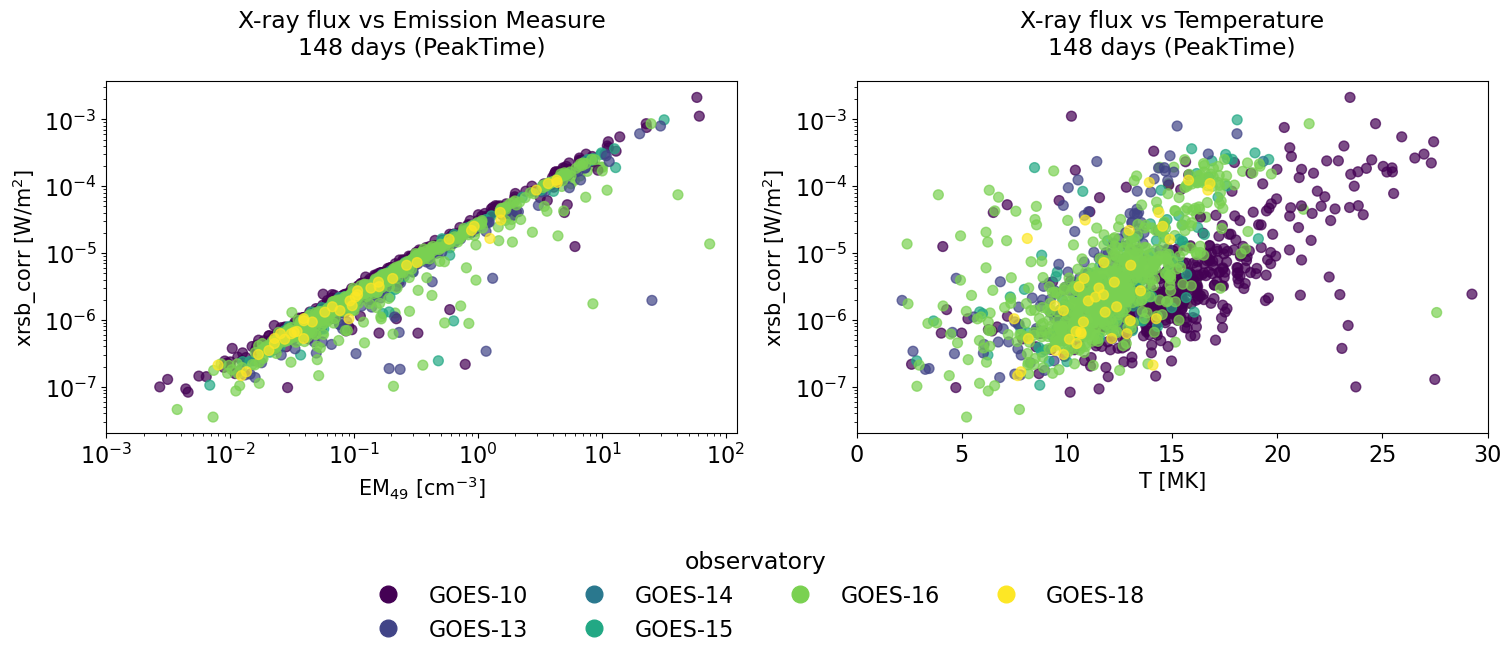

In [8]:

# Uso:
plot_xrs_vs_te_simple(days=new_n, 
                     df_full_valid=df_full_valid, 
                     df_flares_valid=df_flares_valid, 
                     color_by="observatory")

Datos válidos para graficar: 1433


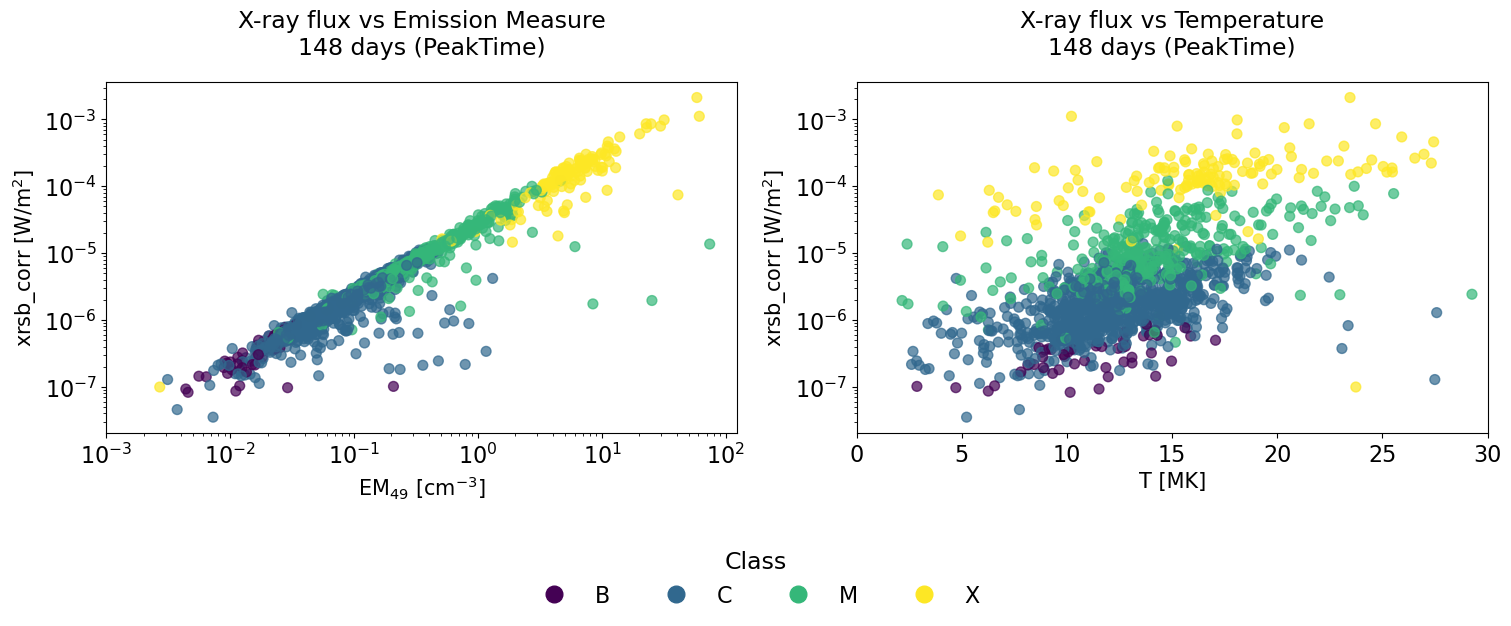

In [9]:
plot_xrs_vs_te_simple(days=new_n, 
                         df_full_valid = df_full_valid, 
                         df_flares_valid = df_flares_valid, 
                         time_column="PeakTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by="Class",
                         palette="viridis",  
                         class_to_color=None)

Datos válidos para graficar: 504


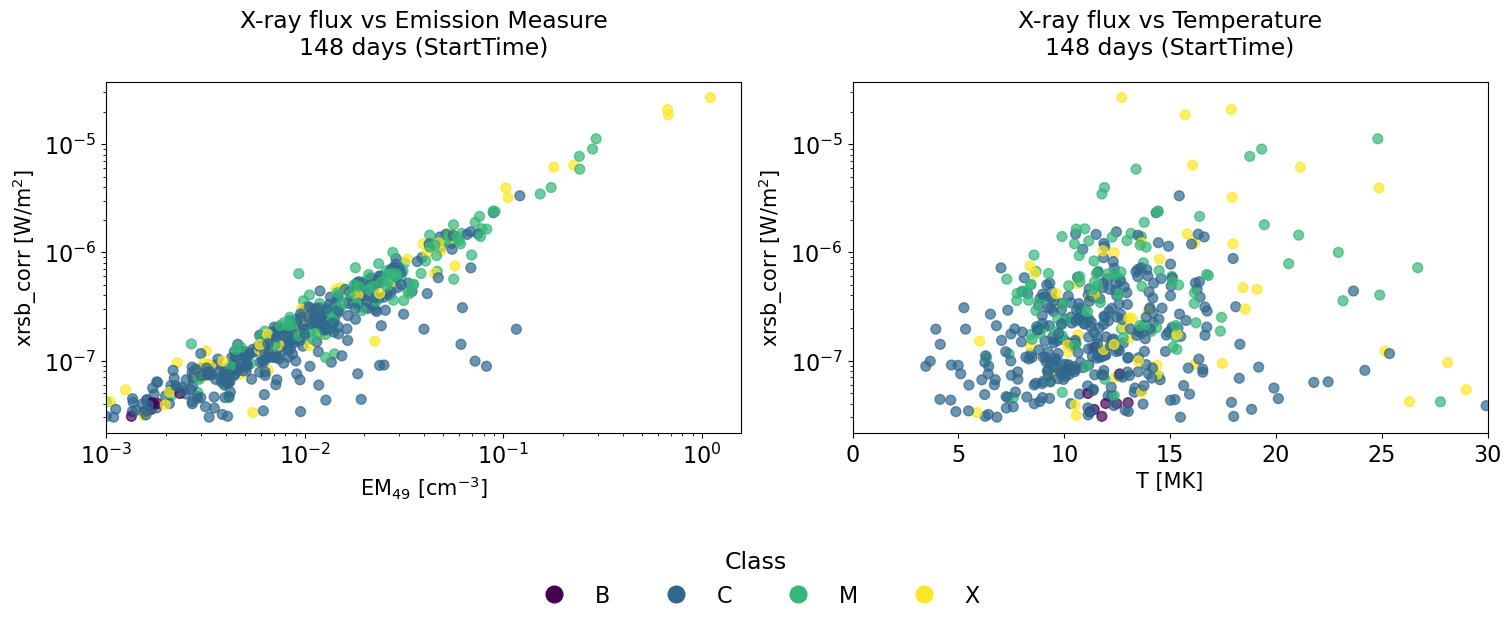

In [10]:
plot_xrs_vs_te_simple(days=new_n, 
                         df_full_valid = df_full_valid, 
                         df_flares_valid = df_flares_valid, 
                         time_column="StartTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by="Class",
                         palette="viridis",  
                         class_to_color=None)

Datos válidos para graficar: 100


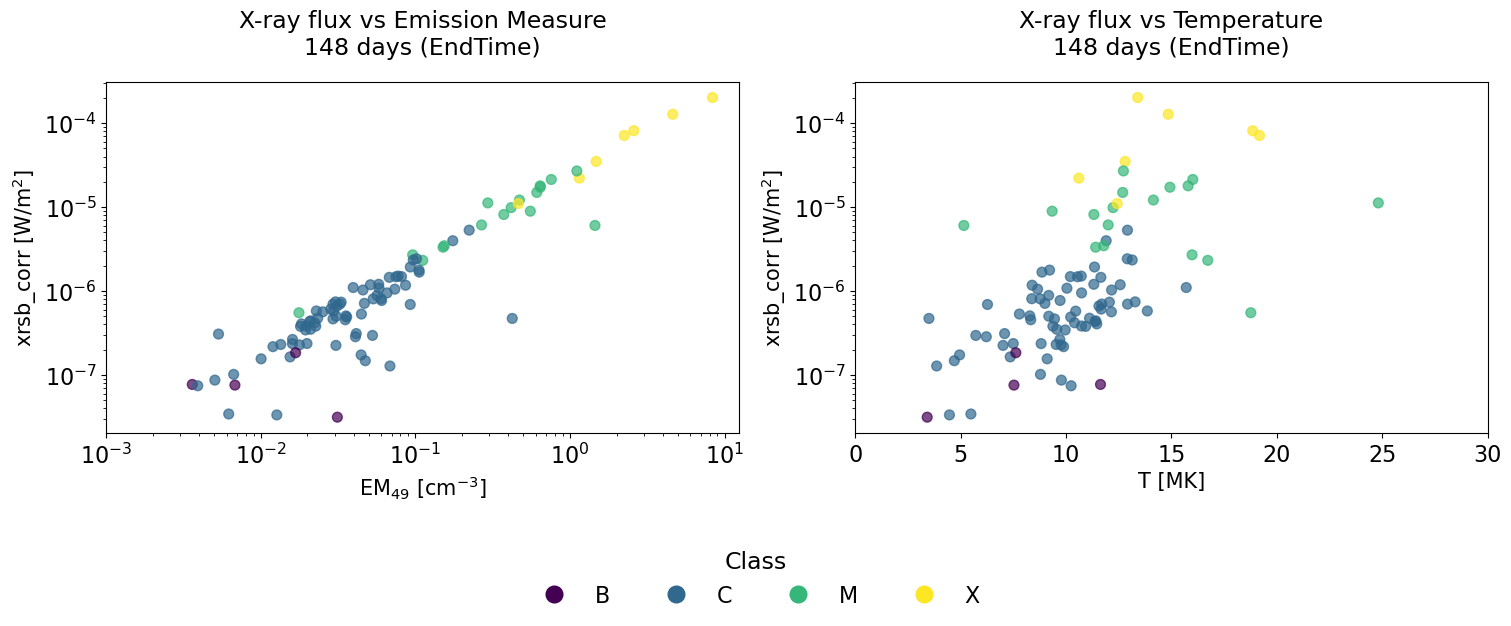

In [11]:
plot_xrs_vs_te_simple(days=new_n, 
                         df_full_valid = df_full_valid, 
                         df_flares_valid = df_flares_valid, 
                         time_column="EndTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by="Class",
                         palette="viridis",  
                         class_to_color=None)

## anticipación vs T y EM

Usando columna de anticipación: AnticipationStart
Datos procesados: 601 flares con anticipación


/tmp/ipykernel_19404/1250330655.py:294: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


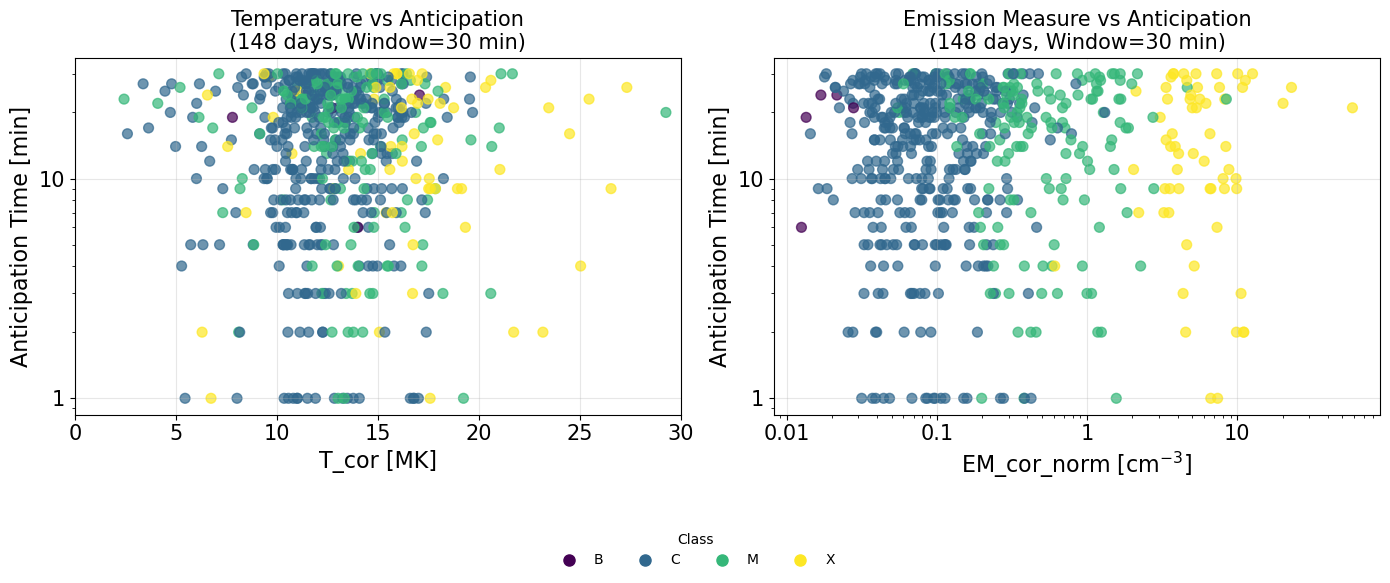

se guardo en: Analysis_FAI/Analysis_FAI_T7-14_EM0.005_dur3min/Graphics_filtered_W30min/148d_AnticipationTime_vs_T_EM_Window30min_ColorClass.png

--- Estadísticas de Anticipación ---
Tiempo de anticipación promedio: 16.5 min
Tiempo de anticipación mediano: 17.0 min
Tiempo de anticipación máximo: 30.0 min
Tiempo de anticipación mínimo: 1.0 min
Temperatura promedio: 13.0 MK
EM promedio: 1.019


In [12]:

plot_anticipation_vs_te_dataframes(
    days=new_n,
    max_gap_fai=window_minutes,
    df_full_valid=df_full_valid,
    df_flares_valid=df_flares_valid,
    df_anticipation_time=df_anticipation_time,
    time_column="PeakTime",
    T="T_cor", 
    EM="EM_cor_norm",
    color_by="Class",
    palette="viridis"
)